# Fake News Detection – Naive Bayes Model

Ten projekt pokazuje krok po kroku:
1. Wczytanie danych (Fake + Real news)
2. Czyszczenie tekstu
3. Wektoryzację TF-IDF
4. Trenowanie modelu Naive Bayes
5. Analizę wyników i wizualizację macierzy pomyłek
6. Wizualizacje tekstu
7. Zastosowanie modelu w nowym tekście

In [3]:
!pip install -r requirements.txt



[notice] A new release of pip is available: 24.2 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [4]:

import pandas as pd

# Wczytaj dane
fake_df = pd.read_csv("Fake.csv")
real_df = pd.read_csv("True.csv")

# Dodaj etykiety
fake_df["label"] = 0  # fake
real_df["label"] = 1  # real

# Połącz dane i wymieszaj
df = pd.concat([fake_df, real_df])
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

# Sprawdzenie
print(df.head())
print("\nRozkład klas:")
print(df["label"].value_counts())


                                               title  \
0  Ben Stein Calls Out 9th Circuit Court: Committ...   
1  Trump drops Steve Bannon from National Securit...   
2  Puerto Rico expects U.S. to lift Jones Act shi...   
3   OOPS: Trump Just Accidentally Confirmed He Le...   
4  Donald Trump heads for Scotland to reopen a go...   

                                                text       subject  \
0  21st Century Wire says Ben Stein, reputable pr...       US_News   
1  WASHINGTON (Reuters) - U.S. President Donald T...  politicsNews   
2  (Reuters) - Puerto Rico Governor Ricardo Rosse...  politicsNews   
3  On Monday, Donald Trump once again embarrassed...          News   
4  GLASGOW, Scotland (Reuters) - Most U.S. presid...  politicsNews   

                  date  label  
0    February 13, 2017      0  
1       April 5, 2017       1  
2  September 27, 2017       1  
3         May 22, 2017      0  
4       June 24, 2016       1  

Rozkład klas:
label
0    23481
1    21417
Name: c

In [5]:

import re
import nltk
from nltk.corpus import stopwords

nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

def clean_text(text):
    text = text.lower()
    text = re.sub(r'\W', ' ', text)
    text = re.sub(r'\s+', ' ', text)
    text = ' '.join([word for word in text.split() if word not in stop_words])
    return text

df["clean_text"] = df["text"].apply(clean_text)


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\mmark\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [6]:

from sklearn.model_selection import train_test_split

X = df["clean_text"]
y = df["label"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Rozmiar zbioru treningowego: {len(X_train)}")
print(f"Rozmiar zbioru testowego: {len(X_test)}")


Rozmiar zbioru treningowego: 35918
Rozmiar zbioru testowego: 8980


In [7]:

from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(max_features=5000)
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

print("Wektoryzacja zakończona.")
print(f"Kształt X_train: {X_train_tfidf.shape}")
print(f"Kształt X_test: {X_test_tfidf.shape}")


Wektoryzacja zakończona.
Kształt X_train: (35918, 5000)
Kształt X_test: (8980, 5000)


In [8]:

from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report

nb_model = MultinomialNB()
nb_model.fit(X_train_tfidf, y_train)
y_pred_nb = nb_model.predict(X_test_tfidf)

print("Wyniki dla Naive Bayes:")
print(classification_report(y_test, y_pred_nb, target_names=["Fake", "Real"]))


Wyniki dla Naive Bayes:
              precision    recall  f1-score   support

        Fake       0.94      0.94      0.94      4696
        Real       0.94      0.93      0.93      4284

    accuracy                           0.94      8980
   macro avg       0.94      0.94      0.94      8980
weighted avg       0.94      0.94      0.94      8980



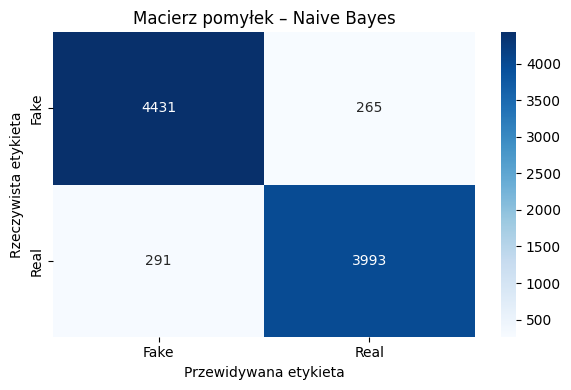

In [9]:

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred_nb)

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Fake', 'Real'],
            yticklabels=['Fake', 'Real'])

plt.title("Macierz pomyłek – Naive Bayes")
plt.xlabel("Przewidywana etykieta")
plt.ylabel("Rzeczywista etykieta")
plt.tight_layout()
plt.show()


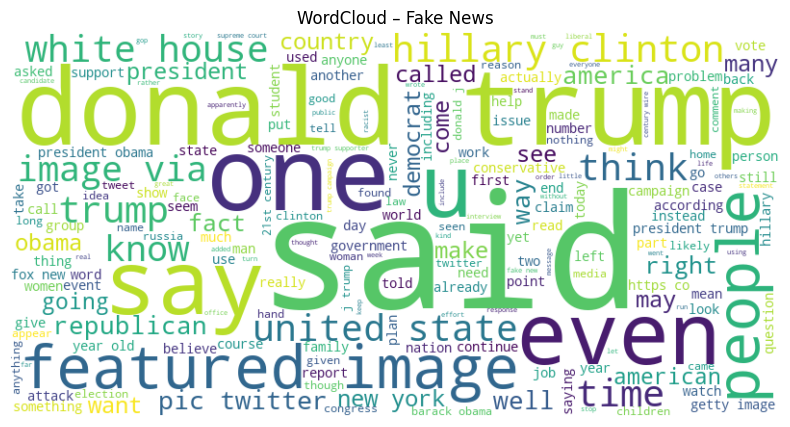

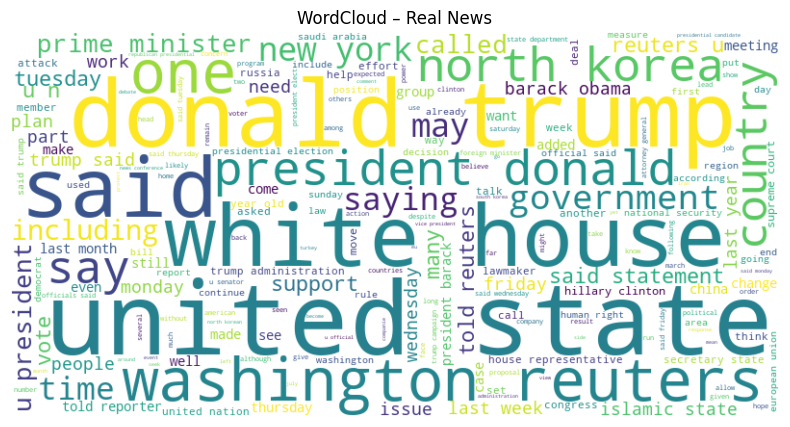

In [10]:

from wordcloud import WordCloud

# Chmura słów dla Fake news
fake_text = " ".join(df[df['label'] == 0]['clean_text'])
wordcloud_fake = WordCloud(width=800, height=400, background_color='white').generate(fake_text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_fake, interpolation='bilinear')
plt.axis("off")
plt.title("WordCloud – Fake News")
plt.show()

# Chmura słów dla Real news
real_text = " ".join(df[df['label'] == 1]['clean_text'])
wordcloud_real = WordCloud(width=800, height=400, background_color='white').generate(real_text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_real, interpolation='bilinear')
plt.axis("off")
plt.title("WordCloud – Real News")
plt.show()


In [11]:

# Funkcja predykcji nowego tekstu
def predict_article(text):
    cleaned = clean_text(text)
    vector = tfidf.transform([cleaned])
    prediction = nb_model.predict(vector)
    return "REAL" if prediction[0] == 1 else "FAKE"

# Przykład użycia
sample_text = "Scientists have discovered a new planet that could support life."
print("Wynik predykcji:", predict_article(sample_text))


Wynik predykcji: FAKE
